## General Linear Models

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_is_instance, assert_true
from numpy.testing import assert_array_almost_equal, assert_almost_equal

In [2]:
filename = '2001-1.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'LAX'] 
local = local.loc[::500] 

print(local.head())

       AirTime Origin  Distance
55790     55.0    LAX       370
64156     44.0    LAX       236
78291     54.0    LAX       337
89730     44.0    LAX       236
96346     71.0    LAX       451


### General Linear Model

In [45]:
def sample_posterior(x, y, n_samples=1000, random_seed=0):
    '''
    A general linear model.
    
    Paramters
    ---------
    x: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    df = pd.DataFrame({'x': x, 'y': y})
    with pm.Model() as model_glm:
        pm.glm.GLM.from_formula('y ~ x', df)
        start = pm.find_MAP()
        step = pm.NUTS()
        trace = pm.sample(n_samples, start=start, step=step, random_seed=random_seed)
    return trace

In [46]:
trace = sample_posterior(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Optimization terminated successfully.
         Current function value: 160.021270
         Iterations: 63
         Function evaluations: 100
         Gradient evaluations: 100


100%|██████████| 2500/2500 [00:05<00:00, 460.02it/s]


### Tests

In [39]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [40]:
assert_true('Intercept' in trace.varnames)
assert_true('x' in trace.varnames)

In [41]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

### Visualization

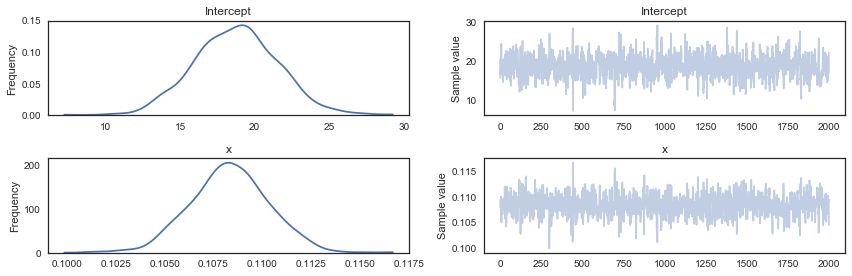

In [42]:
pm.traceplot(trace, ['Intercept', 'x']);

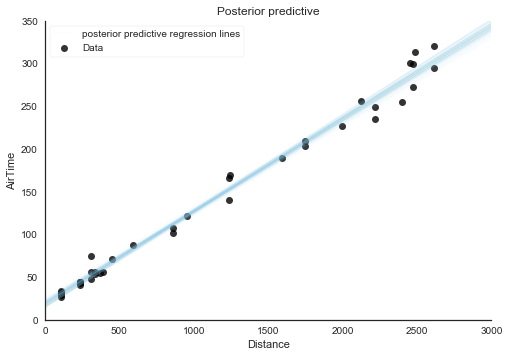

In [43]:
sns.set(style='white')

ax = sns.regplot(data=local, x='Distance', y='AirTime',
                 fit_reg=False, color='k', label="Data")

ax.set_xlim(0, 3000)
ax.set_ylim(0, 350)

x_sample = np.linspace(0, 3000, 2)

pm.plots.plot_posterior_predictive_glm(trace, samples=100, eval=x_sample,
                                 label='posterior predictive regression lines', color='skyblue', alpha=0.2)
sns.despine()

ax.legend(loc='upper left', frameon=True)

plt.show()